### Import Modules

In [260]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

### Load Model

In [261]:
model = YOLO("yolov8m.pt")  # Load the YOLOv8 model
model.fuse()

YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


In [262]:
class_names = model.model.names  # Get class names from the model

#class_names 

In [263]:
#select class id's needed
classes = [2, 3, 5, 7]

### Plot frame from video

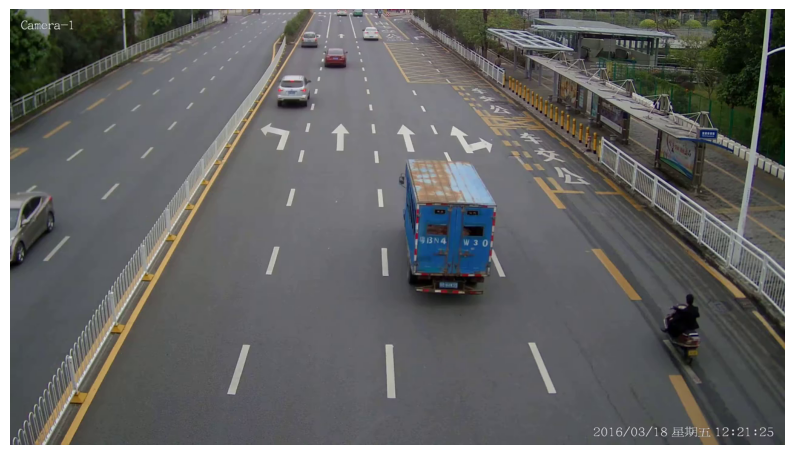

In [264]:
#create a frame generator
generator = sv.get_video_frames_generator('test2.mp4')

iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

### Detect Vehicles from Frame

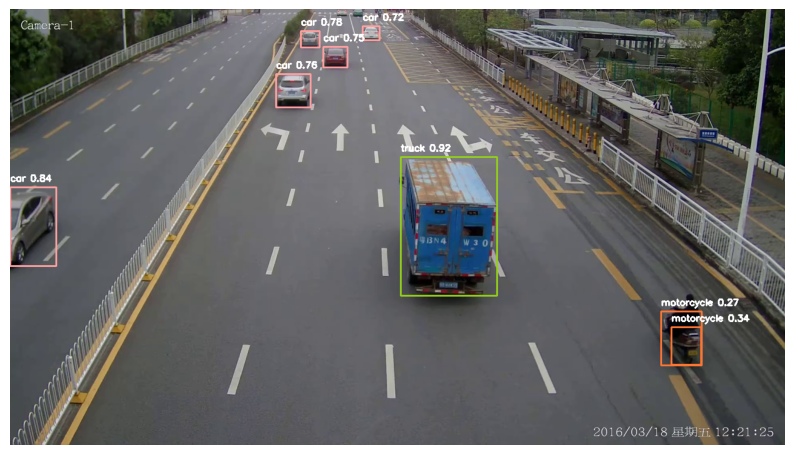

In [265]:
results = model(frame, verbose=False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(results)

#only consider classes we need
detections = detections[np.isin(detections.class_id, classes)]

#create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

#annotate the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

#format and get labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f"{class_names[class_id]} {confidence:0.2f}"
    labels.append(label)

#overlay labels in bounding box
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    #display the text
    cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

sv.plot_image(annotated_frame, (10, 10))

### Track Vehicles

In [266]:
sv.VideoInfo.from_video_path('test1.mp4')

VideoInfo(width=640, height=360, fps=29, total_frames=62730)

In [267]:
#create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate=29)

#create trace annotator
trace_annotator = sv.TraceAnnotator(
    thickness=2,
    trace_length=75
)

In [268]:
#define function for processing frames
def process_frame(frame):
    height, width = frame.shape[:2]
    # Define detection zone (15% margin top and bottom)
    margin_top = int(0.15 * height)
    margin_bottom = int(0.85 * height)
    detection_zone = (0, margin_top, width, margin_bottom - margin_top)  # x, y, w, h

    # Draw detection zone rectangle (green, thickness 2)
    annotated_frame = frame.copy()
    cv2.rectangle(
        annotated_frame,
        (detection_zone[0], detection_zone[1]),
        (detection_zone[0] + detection_zone[2], detection_zone[1] + detection_zone[3]),
        (0, 255, 0), 2
    )

    results = model(frame, verbose=False)[0]

    #convert to detections
    detections = sv.Detections.from_ultralytics(results)

    #only consider classes we need
    detections = detections[np.isin(detections.class_id, classes)]

    # Filter detections to only those inside the detection zone
    # Each box: [x1, y1, x2, y2]
    in_zone = []
    for box in detections.xyxy:
        x1, y1, x2, y2 = box.astype(int)
        # Check if the center of the box is within the detection zone
        center_y = int((y1 + y2) / 2)
        if margin_top <= center_y <= margin_bottom:
            in_zone.append(True)
        else:
            in_zone.append(False)
    in_zone = np.array(in_zone)
    detections = detections[in_zone]

    #tracking detection
    detections = byte_tracker.update_with_detections(detections)

    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f"{tracker_id} {class_names[class_id]} {confidence:0.2f}"
        labels.append(label)

    #update trace annotator
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)

    #update box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    #overlay labels in bounding box
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        #display the text
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return annotated_frame


In [269]:
import cv2
from ultralytics import solutions

video_path = 'test2.mp4'
video_cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not video_cap.isOpened():
    print("Error: Could not open video file")
    exit()

# Video writer
w, h, fps = (int(video_cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
output_path = 'speed_management.avi'
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Initialize speed estimation object
speedestimator = solutions.SpeedEstimator(
    show=True,  # display the output
    model="yolo11n.pt",  # path to the YOLO11 model file.
    fps=fps,  # adjust speed based on frame per second
    max_hist=5,  # minimum frames object tracked before computing speed
    meter_per_pixel=1,  # highly depends on the camera configuration
    line_width=1,  # adjust the line width for bounding boxes
)

frame_count = 0
total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

try:
    print(f"Processing {total_frames} frames...")
    while True:
        success, frame = video_cap.read()
        if not success:
            break
        
        frame_count += 1
        
        # Draw detection zone (15% margin top and bottom)
        margin_top = int(0.15 * h)
        margin_bottom = int(0.85 * h)
        cv2.rectangle(
            frame,
            (0, margin_top),
            (w, margin_bottom),
            (0, 255, 0), 2
        )
        
        results = speedestimator(frame)

        # Write the processed frame to video
        video_writer.write(results.plot_im)

        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Clean up
    video_cap.release()
    video_writer.release()
    cv2.destroyAllWindows()  # destroy all opened windows
    print(f"Video processing completed. Output saved as: {output_path}")
    print(f"Processed {frame_count} frames total.")

Ultralytics Solutions:  {'source': None, 'model': 'yolo11n.pt', 'classes': None, 'show_conf': True, 'show_labels': True, 'region': None, 'colormap': 21, 'show_in': True, 'show_out': True, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'figsize': (12.8, 7.2), 'blur_ratio': 0.5, 'vision_point': (20, 20), 'crop_dir': 'cropped-detections', 'json_file': None, 'line_width': 1, 'records': 5, 'fps': 25, 'max_hist': 5, 'meter_per_pixel': 1, 'max_speed': 120, 'show': True, 'iou': 0.7, 'conf': 0.25, 'device': None, 'max_det': 300, 'half': False, 'tracker': 'botsort.yaml', 'verbose': True, 'data': 'images'}


Processing 1195 frames...
0: 720x1280 50.6ms
Speed: 233.5ms track, 50.6ms solution per image at shape (1, 3, 720, 1280)

0: 720x1280 50.6ms
Speed: 233.5ms track, 50.6ms solution per image at shape (1, 3, 720, 1280)

1: 720x1280 6.2ms
Speed: 138.7ms track, 6.2ms solution per image at shape (1, 3, 720, 1280)

1: 720x1280 6.2ms
Speed: 138.7ms track, 6.2ms solution per image at shape (1, 3, 720, 1280)

2: 720x1280 6.4ms
Speed: 141.1ms track, 6.4ms solution per image at shape (1, 3, 720, 1280)

2: 720x1280 6.4ms
Speed: 141.1ms track, 6.4ms solution per image at shape (1, 3, 720, 1280)

3: 720x1280 6.4ms
Speed: 140.7ms track, 6.4ms solution per image at shape (1, 3, 720, 1280)

3: 720x1280 6.4ms
Speed: 140.7ms track, 6.4ms solution per image at shape (1, 3, 720, 1280)

4: 720x1280 7.4ms
Speed: 137.3ms track, 7.4ms solution per image at shape (1, 3, 720, 1280)

4: 720x1280 7.4ms
Speed: 137.3ms track, 7.4ms solution per image at shape (1, 3, 720, 1280)

5: 720x1280 6.6ms
Speed: 279.8ms track, 

KeyboardInterrupt: 